This IPython Notebook shows an example on how to easliy analyze data produced by ZEN's image analysis.

1. 50 out of of 96 wells were images
2. 9 positions per well were analysed
3. two CSV tables were created
  * one containing the info for all objects per well
  * one containing all single objects
 
Finally the two tables were saved to hard disk. This whole procedure can be completely automated via OAD, if required.
 
**It is also possible to start the analysis steps below from within an OAD macro.**

Remark: This notebook illustrates the possibilities to play around with those data. Not all steps are actually required.

<img src="Data\Zen_Wellplate_Experiment.png" />

In [3]:
# do the required imports
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt

# define the filenames
filename = 'Data\96Well_Ch=1_50Wells_9P_pro_Well_AllRegions.csv'
filename_single = 'Data\96Well_Ch=1_50Wells_9P_pro_Well_SingleRegion.csv'

In [4]:
# read the CSV data table created by ZEN image analysis and show a few rows
df = pd.read_csv(filename, sep=';')
df[:3]

,﻿RegionsCount::Count!!I,ImageSceneContainerName::Image Scene Container Name,ImageSceneColumn::Image Scene Column Index!!I,ImageSceneRow::Image Scene Row Index!!I,ImageIndexPosition::Image Index Position!!I,RegionsIntensityMean_DAPI::Intensity Mean Value of channel 'DAPI'!!R,RegionsMeanArea::Mean Area!!R
0,#,NaN,NaN,NaN,NaN,Gray,µm²
1,326,B2,2,2,1,"82,611747062285","532,88699543558"
2,271,B2,2,2,1,"77,988221463613","538,28068061993"


In [5]:
# delete unneeded rows
df = df.drop([0])
# rename the columns in order to use more descriptive names
df.rename(columns = {
        df.columns[0]: 'CellNumber',
        df.columns[1]: 'WellID',
        df.columns[2]: 'ColumnID',
        df.columns[3]: 'RowID',
        df.columns[4]: 'PositionIndex',
        df.columns[5]: 'DAPI_MeanInt',
        df.columns[6]: 'DAPI_MeanArea'}, inplace=True)

df[:3]

,CellNumber,WellID,ColumnID,RowID,PositionIndex,DAPI_MeanInt,DAPI_MeanArea
1,326,B2,2,2,1,"82,611747062285","532,88699543558"
2,271,B2,2,2,1,"77,988221463613","538,28068061993"
3,244,B2,2,2,1,"108,10610965259","530,26551003279"


In [6]:
# convert columns to meuneric types when possible, since there might be issues determing the correct data types for some columns
df = df.convert_objects(convert_numeric=True)

# convert columns to numeric types when possible --> convert to float
df['DAPI_MeanInt'] = df['DAPI_MeanInt'].str.replace(',', '.').astype('float')
df['DAPI_MeanArea'] = df['DAPI_MeanArea'].str.replace(',', '.').astype('float')

df.dtypes

CellNumber         int64
WellID            object
ColumnID         float64
RowID            float64
PositionIndex    float64
DAPI_MeanInt     float64
DAPI_MeanArea    float64
dtype: object

In [7]:
# define helper function to be able to extract the well labels depending on the actual wellplate type

def ExtractLabels(Nr, Nc):
    # labeling schemes        
    LabelX = ['1','2','3','4','5','6','7','8','9','10','11','12',
              '13','14','15','16','17','18','19','20','21','22','23','24',
              '25','26','27','28','29','30','31','32','33','34','35','36',
              '37','38','39','40','41','42','43','44','45','46','47','48',]
    
    LabelY = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P',
              'Q','R','S','T','U','V','W','X','Y','Z','AA','AB','AC','AD','AE','AF'] 
    
    Lx = LabelX[0:Nc]
    Ly = LabelY[0:Nr]
    
    return Lx, Ly

In [8]:
# create an array containing the number of counted cells per well
Nr = 8
Nc = 12
# fill the array with NaNs at the beginning
well = np.full([Nr, Nc], np.nan)

In [9]:
for i in range(0,df.shape[0]):
    # update well matrix at the correct position - indicies have to be integers ...
    well[int(df['RowID'][i+1]-1), int(df['ColumnID'][i+1]-1)] = df['CellNumber'][i+1]

In [10]:
# get the labels for a 96 well plate and create a dataframe from the numpy array
Lx, Ly = ExtractLabels(8, 12)
well_df = pd.DataFrame(well, index=Ly, columns=Lx)

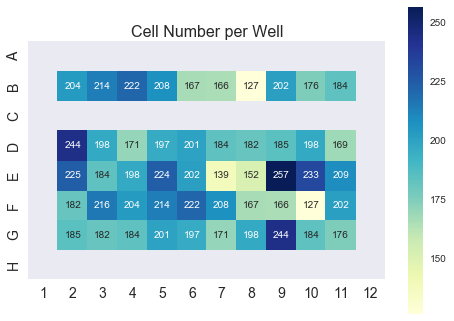

In [11]:
%matplotlib inline
sns.set()
# configire the heatmap plot for the cell number depending on the well positions
ax= sns.heatmap(well_df, cmap="YlGnBu", linecolor='black', annot=True, fmt='3.0f', square=True)
# customize the plot to your needs - make font siozes bigger ...
ax.set_title('Cell Number per Well', fontsize=16)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

In [12]:
# read the CSV table containing all the single object data for further "in-depth" analysis
dfs = pd.read_csv(filename_single, sep=';')
# delete unneeded rows
dfs = dfs.drop([0])
dfs.rename(columns={
    dfs.columns[0]: 'ID',
    dfs.columns[1]: 'WellID',
    dfs.columns[2]: 'ColumnID',
    dfs.columns[3]: 'RowID',
    dfs.columns[4]: 'Index',
    dfs.columns[5]: 'DAPI_Mean',
    dfs.columns[6]: 'Area',
    dfs.columns[7]: 'Perimeter',
    dfs.columns[8]: 'Roundness'}, inplace=True)

# convert columns to numeric types to avoid problems with the data types and decimal separators
dfs['DAPI_Mean'] = dfs['DAPI_Mean'].str.replace(',', '.').astype('float')
dfs['Area'] = dfs['Area'].str.replace(',', '.').astype('float')
dfs['Perimeter'] = dfs['Perimeter'].str.replace(',', '.').astype('float')
dfs['Roundness'] = dfs['Roundness'].str.replace(',', '.').astype('float')

dfs[:3]

,ID,WellID,ColumnID,RowID,Index,DAPI_Mean,Area,Perimeter,Roundness
1,2,B2,2,2,1,88.544643,369.359872,72.898118,0.685591
2,3,B2,2,2,2,89.075472,524.359104,88.930542,0.562352
3,4,B2,2,2,3,127.159184,807.974720,108.412448,0.612860


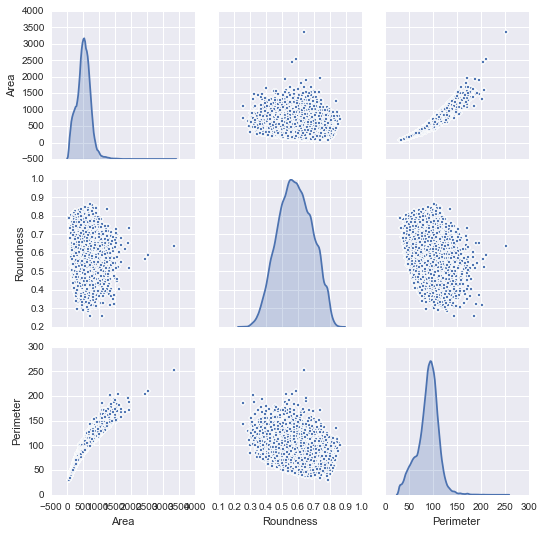

In [11]:
%matplotlib inline
# visualize parametes using the amazing seaborn library in a pairplot using a subset of the variables
g = sns.pairplot(dfs, diag_kind='kde', markers='.',
                 plot_kws=dict(s=50, linewidths=1),
                 diag_kws=dict(shade=True),
                 vars=['Area', 'Roundness', 'Perimeter'])